In [16]:
%matplotlib inline 
import os, sys, glob, pickle
import numpy as np 
import pyemma as py
import matplotlib.pyplot as plt
import seaborn as sns
import mdtraj as md

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# The GPU id to use, usually either "0" or "1"
os.environ["CUDA_VISIBLE_DEVICES"]="1" 

In [3]:
os.environ['PYEMMA_NJOBS'] = '1'
os.environ['OMP_NUM_THREADS'] = '1'

In [4]:
from hde import HDE

Using TensorFlow backend.


In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
import tensorflow as tf
import keras.backend as K
config = tf.ConfigProto()
 
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
 
# Only allow a total of half the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 0.5
 
# Create a session with the above options specified.
K.tensorflow_backend.set_session(tf.Session(config=config))

## Load models

The best models were determined via grid search. See python scripts for details. 

In [7]:
msm_tica = py.load('best_tica_msm.mdl')
tica_viz = py.load('tica_viz.mdl')
cluster_tica = py.load('best_tica_cluster.mdl')

/home/hsidky/miniconda3/envs/dnets2/lib/python3.6/site-packages/pyemma/_base/serialization/pickle_extensions.py:52: UserWarning: BLOSC compression filter unavailable. Your resulting file may be large and not optimal to process.
  warnings.warn('BLOSC compression filter unavailable. '


Load SRV model

In [8]:
hde = pickle.load(open('hde-model-scan/hde_model_078.pkl', 'rb'))

/home/hsidky/miniconda3/envs/dnets2/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [9]:
X = np.load('scaled_features.npy')
Z = hde.transform(X)

In [10]:
W = tica_viz.transform(X)

## Spectral clustering (not used)

In [ ]:
from sklearn.cluster import SpectralClustering
from sklearn.svm import LinearSVC

In [ ]:
scluster = SpectralClustering(n_clusters=100, assign_labels='discretize').fit(Z[::50])

In [ ]:
clf = LinearSVC().fit(Z[::50], scluster.labels_)
y_te = clf.predict(Z)

In [ ]:
fig, ax = plt.subplots(1, figsize=(10, 10))
_, _, misc = py.plots.plot_state_map(
    *W[:,[0, 3]].T, 
    y_te, 
    ax=ax,
    cbar_orientation='horizontal',
    legacy=False
)


# Build MSM and check quality

In [11]:
from pyemma.plots.markovtests import _add_ck_subplot

In [43]:
cluster = py.coordinates.cluster_kmeans(Z, k=200, max_iter=50, n_jobs=1)

In [44]:
its = py.msm.timescales_msm(cluster.dtrajs, nits=8, lags=1000, errors='bayes', nsamples=50, n_jobs=10)
msm = py.msm.bayesian_markov_model(cluster.dtrajs, lag=50, dt_traj='0.2 ns', nsamples=50)

In [67]:
#msm.save('srv_msm_final.mdl')

In [45]:
cktest = msm.cktest(9, mlags=20, n_jobs=8)

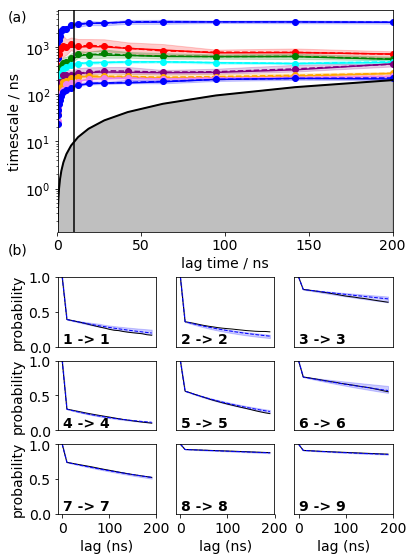

In [55]:
fig = plt.figure(figsize=(6, 7))

gs = plt.GridSpec(1, 1, figure=fig)
gs.update(top=1, bottom=0.56)

sp = gs.new_subplotspec((0, 0))
ax = fig.add_subplot(sp)

py.plots.plot_implied_timescales(its, ax=ax, dt=0.2, units='ns')
plt.axvline(x=10, color='black')

ax.text(-0.15, 0.95, '(a)', transform=ax.transAxes)
ax.text(-0.15, -0.10, '(b)', transform=ax.transAxes)


n_k = 3

gs = plt.GridSpec(3, n_k, figure=fig)
gs.update(top=0.47, bottom=0)

for k in range(3*n_k):
    sp = gs.new_subplotspec((k // n_k, np.mod(k, n_k)))
    ax = fig.add_subplot(sp)
    #ax = plt.subplot2grid((4, 4), (2 + k // 4, np.mod(k, 4)), fig=fig)
    _add_ck_subplot(cktest, ax, k, k, ipos=cktest.nsets - 1, dt=0.2, units='ns', linewidth=1)
    
    if k // n_k != n_k - 1:
        ax.set_xticks([])
        ax.set_xlabel('')
    else:
        ax.set_xlabel('lag (ns)')
        
    if np.mod(k, n_k) != 0:
        ax.set_yticks([])
    else:
        ax.set_ylabel('probability')


plt.savefig('figures/msm_its_cktest.pdf', dpi=300, bbox_inches='tight')
plt.show()

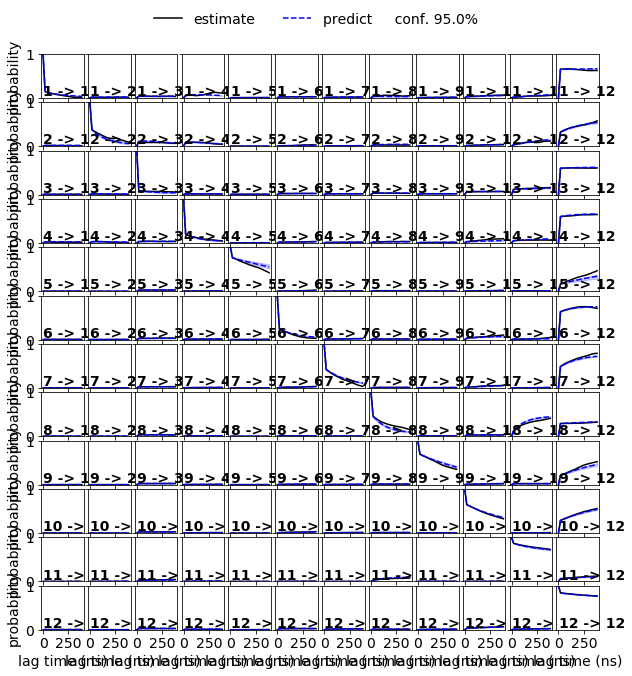

In [706]:
py.plots.plot_cktest(cktest, units='ns', dt=0.2);

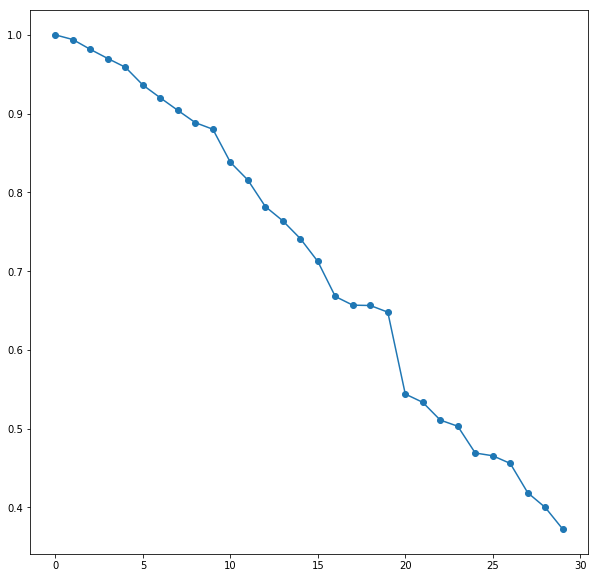

In [13]:
plt.figure(figsize=(10, 10))
plt.plot(msm.eigenvalues()[:30], 'o-')

In [12]:
its_tica_msm = pickle.load(open('best_msm_tica_its.pkl', 'rb'))

In [13]:
from tensorflow.contrib.saved_model import load_keras_model

In [14]:
vnet_prob, vnet_lag, vnet_its = pickle.load(open('vampnet/evals.pkl', 'rb'))

In [15]:
from matplotlib import cycler

/home/hsidky/miniconda3/envs/dnets2/lib/python3.6/site-packages/matplotlib/legend.py:593: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fbef8ae86a0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))
/home/hsidky/miniconda3/envs/dnets2/lib/python3.6/site-packages/matplotlib/legend.py:593: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fbef8ae87f0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))
/home/hsidky/miniconda3/envs/dnets2/lib/python3.6/site-packages/matplotlib/legend.py:593: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fbef8ae8940> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))
/home/hsidky/miniconda3/envs/dnets2/lib/python3.6/site-packages/matplotlib/legend.py:593: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fbef8ae8a90

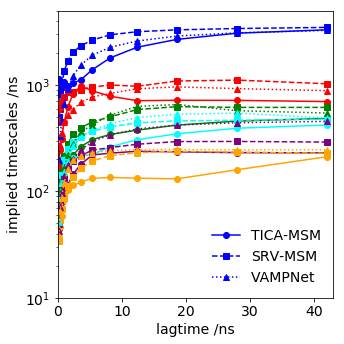

In [21]:
nlags = 13

plt.rcParams['font.size'] = 14

colors = ['blue', 'red', 'green', 'cyan', 'purple', 'orange', 'violet']
fig, ax = plt.subplots(1, figsize=(5, 5))

ax.set_prop_cycle(cycler(color=colors))
ax.semilogy(its_tica_msm.lags[:nlags]*0.2, its_tica_msm.get_timescales()[:nlags]*0.2, 'o-')

ax.set_prop_cycle(cycler(color=colors))
ax.semilogy(its.lags[:nlags]*0.2, its.get_timescales()[:nlags,:6]*0.2, 's--')

#VAMPNets
vn_idx = np.array([np.argwhere(i == vnet_lag)[0][0] for i in its_tica_msm.lags[:nlags]])
ax.set_prop_cycle(cycler(color=colors))
ax.semilogy(vnet_lag[vn_idx][:nlags]*0.2, vnet_its[::-1].T[vn_idx][:nlags, :6]*0.2, '^:')

ax.set_xlim([0, 43])
ax.set_ylim([1e1, 5e3])

ax.set_xlabel('lagtime /ns')
ax.set_ylabel('implied timescales /ns')
ax.legend(['TICA-MSM'] + ['_nolegend_']*5 + ['SRV-MSM'] + ['_nolegend_']*5 + ['VAMPNet'], loc=4, frameon=False)

plt.tight_layout()
plt.savefig('figures/tica_hde_its_comparison.pdf', dpi=300)
plt.show()

## Coarse-grain

In [56]:
pcca = msm.pcca(9);

### Plot discrete states for visual confirmation

In [57]:
viz_coords = [
    [0, 1],
    [0, 2],
    [0, 4],
    [5, 6],
    [2, 3]
]

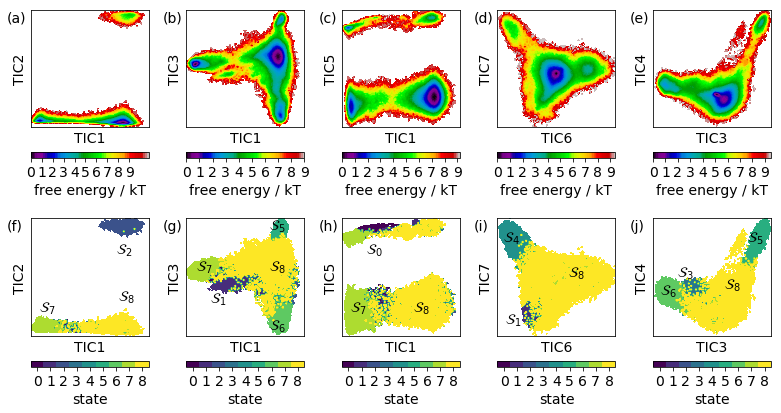

In [60]:
state_labels = [r'$\mathcal{{S}}_{}$'.format(i) for i in range(9)]
abc = ['a', 'b', 'c', 'd' ,'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n']

plt.rcParams['font.size'] = 14
fig, axes = plt.subplots(2, 5, figsize=(11, 6))

for i in range(5):
    coords = viz_coords[i]

    _, _, misc = py.plots.plot_free_energy(
        *W[:, coords].T,
        weights=np.concatenate(msm.trajectory_weights()),
        ax=axes[0, i],
        legacy=False,
        cbar_orientation='horizontal'
    )
    
    axes[0,i].text(-0.2, 0.90, '({})'.format(abc[i]), transform=axes[0,i].transAxes)
    axes[1,i].text(-0.2, 0.90, '({})'.format(abc[i+5]), transform=axes[1,i].transAxes)
    
    axes[0,i].set_xlabel('TIC{}'.format(coords[0] + 1))
    axes[0,i].set_ylabel('TIC{}'.format(coords[1] + 1))
    axes[1,i].set_xlabel('TIC{}'.format(coords[0] + 1))
    axes[1,i].set_ylabel('TIC{}'.format(coords[1] + 1))

    cbar = misc['cbar']
    cbar.set_ticks(np.arange(0, 10, 1))

    _, _, misc= py.plots.plot_state_map(
        *W[:,coords].T, 
        msm.metastable_assignments[cluster.dtrajs], 
        ax=axes[1, i],
        cbar_orientation='horizontal',
    
    )

# Clean up axes.
for axx in axes.flat:
    axx.set_xticks([])
    axx.set_yticks([])

# Label states.
axes[1,0].text(0.72, 0.7, state_labels[2], transform=axes[1,0].transAxes)
axes[1,0].text(0.07, 0.2, state_labels[7], transform=axes[1,0].transAxes)
axes[1,0].text(0.74, 0.3, state_labels[8], transform=axes[1,0].transAxes)

axes[1,1].text(0.08, 0.55, state_labels[7], transform=axes[1,1].transAxes)
axes[1,1].text(0.20, 0.28, state_labels[1], transform=axes[1,1].transAxes)
axes[1,1].text(0.70, 0.55, state_labels[8], transform=axes[1,1].transAxes)
axes[1,1].text(0.70, 0.90, state_labels[5], transform=axes[1,1].transAxes)
axes[1,1].text(0.70, 0.05, state_labels[6], transform=axes[1,1].transAxes)

axes[1,2].text(0.20, 0.7, state_labels[0], transform=axes[1,2].transAxes)
axes[1,2].text(0.07, 0.2, state_labels[7], transform=axes[1,2].transAxes)
axes[1,2].text(0.60, 0.2, state_labels[8], transform=axes[1,2].transAxes)

axes[1,3].text(0.05, 0.8, state_labels[4], transform=axes[1,3].transAxes)
axes[1,3].text(0.06, 0.1, state_labels[1], transform=axes[1,3].transAxes)
axes[1,3].text(0.60, 0.5, state_labels[8], transform=axes[1,3].transAxes)

axes[1,4].text(0.20, 0.5, state_labels[3], transform=axes[1,4].transAxes)
axes[1,4].text(0.80, 0.8, state_labels[5], transform=axes[1,4].transAxes)
axes[1,4].text(0.06, 0.35, state_labels[6], transform=axes[1,4].transAxes)
axes[1,4].text(0.60, 0.4, state_labels[8], transform=axes[1,4].transAxes)

plt.tight_layout()
plt.savefig('figures/hde_msm_free_energy_states.pdf', dpi=300)
plt.show()

## Mean first passage time and mechanism

In [674]:
A_states = np.array([0])
B_states = np.array([1])
B_states = np.setdiff1d(B_states, A_states)

In [675]:
A = np.concatenate(np.array(msm.metastable_sets)[A_states])
B = np.concatenate(np.array(msm.metastable_sets)[B_states])
print('MFPT 1 -> other: ({:6.1f} ± {:5.1f}) ns'.format(
    msm.sample_mean('mfpt', A, B), msm.sample_std('mfpt', A, B)))
print('MFPT other -> 1: ({:.1f} ± {:5.1f}) ns'.format(
    msm.sample_mean('mfpt', B, A), msm.sample_std('mfpt', B, A)))


MFPT 1 -> other: (2970.0 ± 171.4) ns
MFPT other -> 1: (13936.5 ± 714.8) ns


In [24]:
pcca = msm.pcca(9);

In [710]:
T = pcca.coarse_grained_transition_matrix.copy()

In [711]:
T[T < 0]

array([-2.04722599e-05, -2.06920380e-04, -1.58709593e-04, -3.94076410e-04,
       -1.68670717e-03, -8.58479191e-03, -1.18566041e-05, -1.17348352e-04,
       -1.74691521e-04, -1.89320479e-04, -6.02056808e-06, -4.07849046e-05,
       -1.76553691e-04, -5.88612413e-06, -2.18252879e-04, -1.06759220e-03,
       -2.06279696e-03, -9.29536045e-04, -2.23470540e-05, -2.55854191e-04,
       -1.86116457e-03, -9.39510263e-04, -2.81923989e-04, -1.90865015e-03,
       -2.01615675e-04, -8.80894406e-06, -9.17358369e-05, -1.85981267e-04,
       -8.53100887e-04, -2.02337847e-03, -8.97869358e-04, -1.79791336e-05,
       -1.73013021e-03, -7.36822225e-04, -6.74827388e-06, -8.66005445e-05,
       -7.03490755e-05, -9.82131289e-04, -1.62334163e-03])

In [712]:
T[T < 0] *= 0
T = T/T.sum(axis=1)[:, np.newaxis]

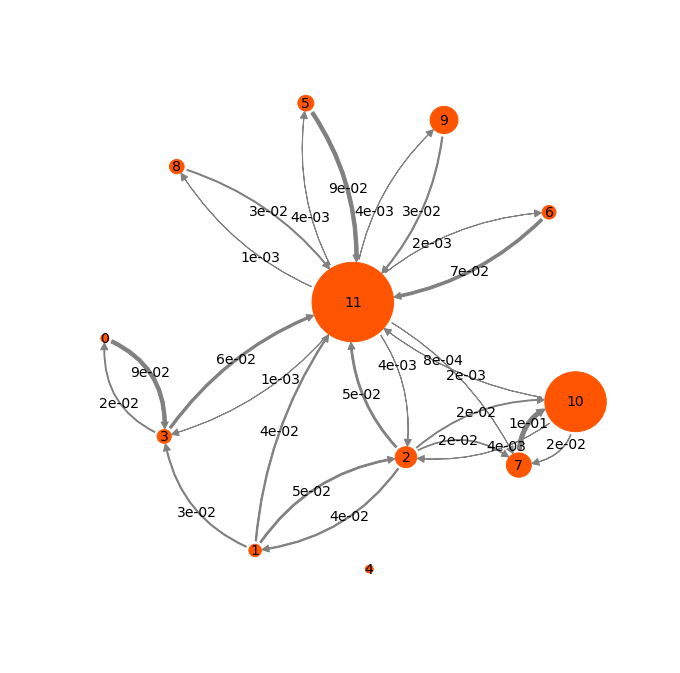

In [739]:
fig, pos = py.plots.plot_markov_model(T, minflux=35e-5);

## Compute properties

Load trajectory

In [17]:
trj_dir = "/home/hsidky/Data/DESRES-Trajectory_2JOF-0-protein/2JOF-0-protein"
trj_file = os.path.join(trj_dir, "trp-cage_rmsdmin.dcd")
pdb_file = os.path.join(trj_dir, "2JOF-0-protein.pdb")

In [18]:
traj = md.load(trj_file, top=pdb_file)

In [19]:
ref = md.load('2jof.pdb')

/home/hsidky/miniconda3/envs/dnets2/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


Compute some properties of the macrostates

### Polyproline stuff

In [20]:
torsion_atoms = traj.top.select("name CA")
tor1 = torsion_atoms[16:]
tor2 = torsion_atoms[15:-1]
tori = np.vstack([tor1, tor2])

In [21]:
torsions = md.geometry.compute_dihedrals(traj, indices=tori)

In [25]:
s1_idx = msm.metastable_assignments[np.concatenate(cluster.dtrajs)] == 2
sn1_idx = msm.metastable_assignments[np.concatenate(cluster.dtrajs)] != 2

In [26]:
(phi_idx, phi) = md.geometry.compute_phi(traj)
(psi_idx, psi) = md.geometry.compute_psi(traj)

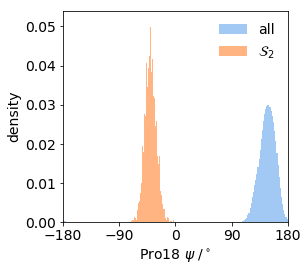

In [584]:
plt.rcParams['font.size'] = 14
sns.set_palette('pastel')
fig, ax = plt.subplots(1, figsize=(4.5, 4))
ax.hist(psi[sn1_idx,17]*180/np.pi, bins=200, density=True);
ax.hist(psi[s1_idx,17]*180/np.pi, bins=200, density=True);
ax.set_ylabel('density')
ax.set_xlabel(r'$\mathrm{Pro18}\ \psi\ /^\circ$')
ax.set_xlim([-180, 180])
ax.set_xticks([-180, -90, 0, 90, 180]);
ax.legend([r'all', r'$\mathcal{S}_2$'], frameon=False)

plt.tight_layout()
plt.savefig('figures/torsion_dist.pdf', dpi=300)
plt.show()

/home/hsidky/miniconda3/envs/dnets2/lib/python3.6/site-packages/ipykernel/__main__.py:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


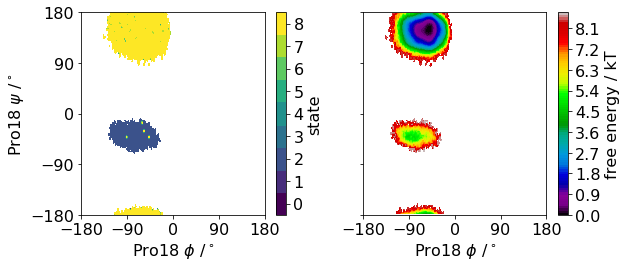

In [585]:
plt.rcParams['font.size'] = 16
fig, ax = plt.subplots(1, 2, figsize=(9, 4), sharex=True, sharey=True)
py.plots.plot_state_map(
    phi[:, 17]*180/np.pi,
    psi[:, 17]*180/np.pi,
    msm.metastable_assignments[cluster.dtrajs],
    ax=ax[0])

py.plots.plot_free_energy(
    phi[:, 17]*180/np.pi,
    psi[:, 17]*180/np.pi,
    weights=np.concatenate(msm.trajectory_weights()),
    ax=ax[1])

for axx in ax:
    axx.set_xlim([-180, 180])
    axx.set_ylim([-180, 180])
    axx.set_xticks([-180, -90, 0, 90, 180]);
    axx.set_yticks([-180, -90, 0, 90, 180]);
    axx.set_xlabel(r'$\mathrm{Pro18}\ \phi\ /^\circ$')

ax[0].set_ylabel(r'$\mathrm{Pro18}\ \psi\ /^\circ$')
plt.tight_layout()
plt.savefig('figures/torsion_dist.pdf', dpi=300)
plt.show()

### Stationary distribution

In [615]:
print('state\tπ\t\tG/kT')
for i, s in enumerate(msm.metastable_sets):
    p = msm.pi[s].sum()
    print('\\mathcal{{S}}_{} & {:.6f} & {:.3f}  \\\\'.format(i, p, -np.log(p)))

state	π		G/kT
\mathcal{S}_0 & 0.004837 & 5.332  \\
\mathcal{S}_1 & 0.008090 & 4.817  \\
\mathcal{S}_2 & 0.006681 & 5.009  \\
\mathcal{S}_3 & 0.016846 & 4.084  \\
\mathcal{S}_4 & 0.012673 & 4.368  \\
\mathcal{S}_5 & 0.020058 & 3.909  \\
\mathcal{S}_6 & 0.075622 & 2.582  \\
\mathcal{S}_7 & 0.168266 & 1.782  \\
\mathcal{S}_8 & 0.686928 & 0.376  \\


### 310 helix

In [61]:
helix_310 = traj.top.select('resid >= 11 and resid <= 14 and mass > 2')
helix_310_ref = ref.top.select('resid >= 11 and resid <= 14 and mass > 2')

In [62]:
rmsd_310 = md.rmsd(traj.atom_slice(helix_310), ref.atom_slice(helix_310_ref))

In [63]:
s0_idx = msm.metastable_assignments[np.concatenate(cluster.dtrajs)] == 0
s1_idx = msm.metastable_assignments[np.concatenate(cluster.dtrajs)] == 1
s7_idx = msm.metastable_assignments[np.concatenate(cluster.dtrajs)] == 7

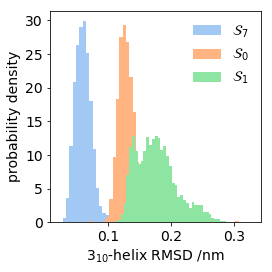

In [66]:
plt.rcParams['font.size'] = 14
sns.set_palette('pastel')
fig, ax = plt.subplots(1, figsize=(4, 4))

ax.hist(rmsd_310[s7_idx], bins=50, density=True);
ax.hist(rmsd_310[s0_idx], bins=50, density=True);
ax.hist(rmsd_310[s1_idx], bins=50, density=True);
ax.set_ylabel('probability density')
ax.set_xlabel(r'$3_{10}$-helix RMSD /nm')
ax.legend([r'$\mathcal{S}_7$', r'$\mathcal{S}_0$', r'$\mathcal{S}_1$'], frameon=False)

plt.tight_layout()
plt.savefig('figures/310_dist.pdf', dpi=300)
plt.show()

### 3_10 helix more details

In [76]:
_, phi_s0 = md.compute_phi(traj[s0_idx])
_, phi_s1 = md.compute_phi(traj[s1_idx])
_, phi_s7 = md.compute_phi(traj[s7_idx])
_, psi_s0 = md.compute_psi(traj[s0_idx])
_, psi_s1 = md.compute_psi(traj[s1_idx])
_, psi_s7 = md.compute_psi(traj[s7_idx])

In [124]:
all_torsions = [ 
    [phi_s0, psi_s0],
    [phi_s1, psi_s1],
    [phi_s7, psi_s7]
]

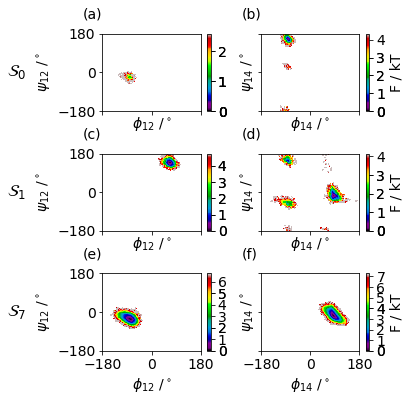

In [146]:
fig, axes = plt.subplots(3, 2, figsize=(5.5, 5.5), sharex=True, sharey=True)
labels = ['a', 'b', 'c', 'd', 'e', 'f']
states = [r'$\mathcal{S}_0$', r'$\mathcal{S}_1$', r'$\mathcal{S}_7$']
extra_artists = []
for k, (phi, psi) in enumerate(all_torsions):
    
    ax = axes[k,:]
        
    _, _, misc1 = py.plots.plot_free_energy(phi[:, 11]*180/np.pi, psi[:, 11]*180/np.pi, ax=ax[0], legacy=False)
    _, _, misc2 = py.plots.plot_free_energy(phi[:, 13]*180/np.pi, psi[:, 13]*180/np.pi, ax=ax[1], legacy=False)
    
    cbar1 = misc1['cbar']
    cbar1.set_ticks([int(x) for x in cbar1.get_ticks()])
    cbar1.set_label('')
    
    cbar2 = misc2['cbar']
    cbar2.set_ticks([int(x) for x in cbar2.get_ticks()])
    cbar2.set_label('F / kT')
    
    t1 = ax[0].text(-0.2, 1.2, f'({labels[2*k]})', transform=ax[0].transAxes)
    t2 = ax[1].text(-0.2, 1.2, f'({labels[2*k+1]})', transform=ax[1].transAxes)
    ax[0].set_xlabel(f'$\phi_{{12}}\ / ^\circ$')
    ax[0].set_ylabel(f'$\psi_{{12}}\ / ^\circ$')
    ax[1].set_xlabel(f'$\phi_{{14}}\ / ^\circ$')
    ax[1].set_ylabel(f'$\psi_{{14}}\ / ^\circ$')
    
    
    t3 = ax[0].annotate(
        states[k], xy=(0, 0.5), xytext=(-ax[0].yaxis.labelpad - 5, 0), 
        xycoords=ax[0].yaxis.label, textcoords='offset points',
        size='large', ha='right', va='center')    
    
    for axx in ax:
        axx.set_xlim([-180, 180])
        axx.set_ylim([-180, 180])
        axx.set_xticks([-180, 0, 180])
        axx.set_yticks([-180, 0, 180])
        
    extra_artists += [t1, t2, t3]
# ax[0].set_title(r'$\mathcal{S}_0$')
# ax[1].set_title(r'$\mathcal{S}_1$')
# ax[2].set_title(r'$\mathcal{S}_7$')

        
plt.tight_layout()
plt.savefig('figures/torsion_compare_folded.pdf', bbox_extra_artists=extra_artists, bbox_inches='tight', dpi=300)

## Visualize macrostates

In [220]:
from matplotlib import patches

In [222]:
pcca_samples = msm.sample_by_distributions(msm.metastable_distributions, 20)

trj_source = py.coordinates.source(trj_file, top=pdb_file)
py.coordinates.save_trajs(
    trj_source,
    pcca_samples,
    outfiles=["./macrostates/pcca{}_20samples.pdb".format(n)
              for n in range(msm.n_metastable)]);

In [595]:
pos = np.array([
[0.05, 0.85584631],
[0.15        , 0.48220325],
[0.82684707, 0.7927297 ],
[0.35140456, 0.0531295 ],
[0.46240695, 0.92550249],
[1.        , 0.36827589],
[0.8       , 0.1        ],
[0., 0.18804033],
[0.45664688, 0.47098073]
])

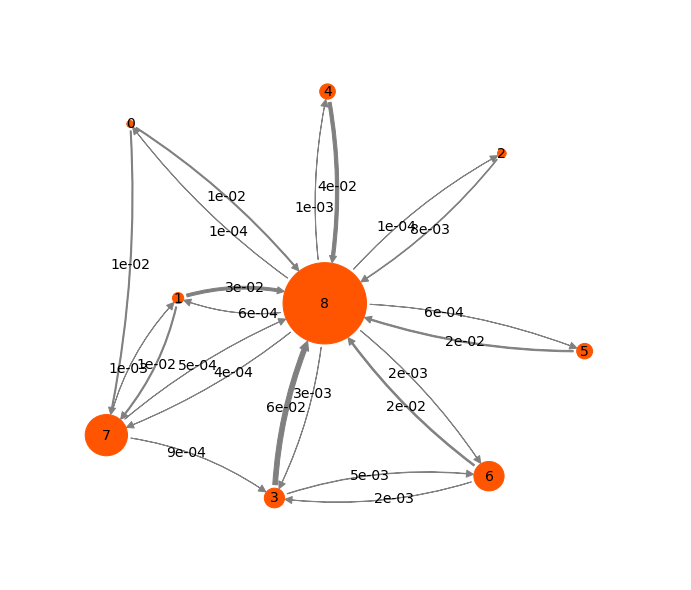

In [596]:
fig, pos = py.plots.plot_markov_model(T, minflux=5.6e-5, pos=pos, arrow_curvature=0.6);

/home/hsidky/miniconda3/envs/dnets2/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


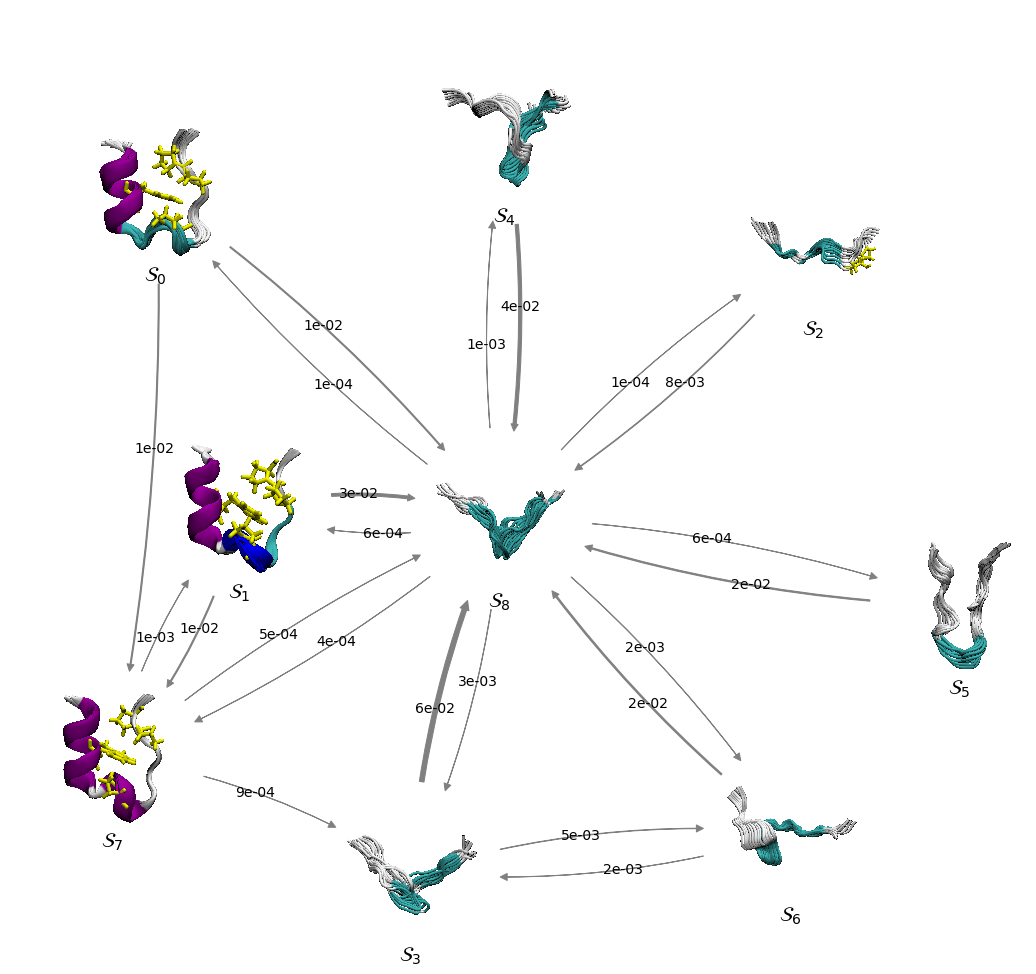

In [611]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize=(12, 12))
gw = int(np.floor(0.5 + 1000 * fig.get_figwidth()))
gh = int(np.floor(0.5 + 1000 * fig.get_figheight()))
gs = plt.GridSpec(gh, gw)
gs.update(hspace=0.0, wspace=0.0, left=0.0, right=1.0, bottom=0.0, top=1.0)
ax_box = fig.add_subplot(gs[:, :])

_, coor = py.plots.plot_markov_model(
    T, 
    minflux=5.6e-5, 
    ax=ax_box, 
    state_sizes=np.array([1]*msm.n_metastable), 
    state_scale=2,
    arrow_scale=1,
    arrow_curvature=0.6,
    state_colors='#ffffff',
    pos=pos,
    state_labels=None,
    figpadding=0.01)

# Remove circles
for child in ax_box.get_children():
    if isinstance(child, patches.Circle):
        child.remove()

xl = ax_box.get_xlim()
yl = ax_box.get_ylim()
fsize = 0.15
for i, (x,y) in enumerate(coor):
    ax_ = fig.add_axes([(x-xl[0])/(xl[1]-xl[0])-fsize/2, (y-yl[0])/(yl[1]-yl[0])-fsize/2, fsize, fsize], zorder=-1)
    ax_.set_axis_off()
    ax_.imshow(plt.imread('macrostates/state_{}.bmp'.format(i)), zorder=-1)
    ax_box.text(x-fsize*0.1, y-fsize*0.7, r'$\mathcal{{S}}_{}$'.format(i), fontsize=20, weight='heavy')


fig.tight_layout()
plt.savefig('figures/flux_viz.pdf', dpi=300, bbox_inches='tight')
plt.show()

## NGLView

In [42]:
import nglview as nv 
import mdtraj as md

In [45]:
traj = md.load(trj_file, top=pdb_file)

In [81]:
idx_msm = msm.metastable_assignments[np.concatenate(cluster.dtrajs)] == 6

In [82]:
view = nv.show_mdtraj(traj[idx_msm])
#view.add_trajectory(md.load(pdb_file))
view[0].add_licorice('TRP')
#view[1].add_ball_and_stick('TRP')
view[0].add_licorice('12')
#view[1].add_ball_and_stick('12')
view

NGLWidget(count=80825)

## Hidden MSM

In [ ]:
cluster_hmm = py.coordinates.cluster_kmeans(Z, k=50, max_iter=50, n_jobs=2)

In [ ]:
#hmm_its = py.msm.timescales_msm(cluster_hmm.dtrajs, nits=7, lags=1000, errors='bayes', nsamples=50)
hmm = py.msm.bayesian_hidden_markov_model(cluster_hmm.dtrajs, 7, lag=50, dt_traj='0.2 ns', nsamples=50)

In [ ]:
py.plots.plot_cktest(hmm.cktest(mlags=10), units='ns', dt=0.2);

In [ ]:
fig, ax = plt.subplots(1, figsize=(13, 10))

_, _, misc = py.plots.plot_state_map(
    *W[:,[0, 2]].T, 
    msm.metastable_assignments[cluster.dtrajs], 
    ax=ax,
    cbar_orientation='horizontal',
    legacy=False
)

In [ ]:
fig, ax = plt.subplots(1, figsize=(13, 10))
_, _, misc = py.plots.plot_state_map(
    *W[:,[0, 2]].T, 
    hmm.metastable_assignments[cluster_hmm.dtrajs], 
    ax=ax,
    cbar_orientation='horizontal',
    legacy=False
)

In [ ]:
np.sum(idx_hmm != idx_msm)

In [ ]:
np.unique(hmm.metastable_assignments[np.concatenate(cluster_hmm.dtrajs)], return_counts=True)

In [ ]:
frames = hmm.metastable_assignments[cluster_hmm.dtrajs]

In [ ]:
py.plots.plot_markov_model(hmm);